In [77]:
import matplotlib.pyplot as plt
from dysh.fits.gbtfitsload import GBTFITSLoad
import numpy as np
from scipy.stats import median_abs_deviation
import astropy.units as u
import time

In [89]:
class Reduce:
    def __init__(self, filename, BC_name):
        self.filename = filename
        self.BC_name = BC_name
        self.data = GBTFITSLoad(filename, backend = "VEGAS")
        self.index = np.where(self.data.summary()["OBJECT"] == self.BC_name)[0]
        self.scans = self.data.summary()["SCAN"][self.index]
    def show_flag(self):
        return self.data.flags.show()
    def show_summary(self):
        return self.data.summary()
    def create_flags(self):
        flag_list = []
        median_flux_array = np.array([])
        MAD_flux_array = np.array([])

        # Iterate over each scan in BC22_scans
        for scans in self.scans[::2]:
            print(f"Processing scan: {scans}")
            # Load the spectra for the current scan
            Single_spectra1 = self.data.getps(scan=scans, plnum=0)
            Single_spectra = Single_spectra1.timeaverage()
            flux_values = Single_spectra.flux.value  # Access flux values once

            # Calculate median flux and MAD flux for the current spectra
            median_flux = np.median(flux_values)
            median_flux_array = np.append(median_flux_array, median_flux)
            MAD_flux = median_abs_deviation(flux_values)
            MAD_flux_array = np.append(MAD_flux_array, MAD_flux)

            # Create a flag mask for values outside the median ± 5 * MAD range
            flag_mask = np.logical_or(flux_values < median_flux - 5 * MAD_flux,
                                    flux_values > median_flux + 5 * MAD_flux)
            flag_chan = np.where(flag_mask)[0]

            # Define bounds and band for flagging
            lower_bound = 800
            upper_bound = 31000
            band = 5
            offsets = np.arange(-band, band + 1)

            # Filter valid flags within the bounds and create new_flag_chan using NumPy operations
            valid_flags = flag_chan[(flag_chan > lower_bound) & (flag_chan < upper_bound)]
            new_flag_chan = np.unique(np.concatenate([valid_flags + offset for offset in offsets] + 
                                                    [np.array([i for i in range(0, lower_bound)])] + 
                                                    [np.array([i for i in range(upper_bound, len(flux_values))])]))
            new_flag_chan = [int(i) for i in new_flag_chan if i >= 0 and i < len(flux_values)]
            print(f"{scans} number, flags:", new_flag_chan)

            # Flag the channels in the current scan
            self.data.flag(scan=scans, channel=new_flag_chan, plnum=0)

            # Check if scans+1 is within a valid range before flagging
            if scans + 1 <= max(self.scans):
                self.data.flag(scan=scans + 1, channel=new_flag_chan, plnum=0)

            # Append the new_flag_chan to the flag_list
            flag_list.append(new_flag_chan)
        self.MAD_flux_array = MAD_flux_array
        self.median_flux_array = median_flux_array
    def dropping_bad_scans(self):
        index_to_drop = np.where(self.MAD_flux_array > 5*np.mean(self.MAD_flux_array))[0]
        if index_to_drop.size > 0:  # Check if index_to_drop is not empty
            self.scans = [scan for i, scan in enumerate(self.scans) if i not in index_to_drop]
    def clean_spectrum(self):
        clean_spectra_sandblock = self.data.getps(scan=self.scans, plnum=0)
        self.clean_spectra = clean_spectra_sandblock.timeaverage()
        self.clean_spectra.plot(xaxis_unit="chan")
        self.flagged_flux_values = self.clean_spectra.flux.value 
    def baselining(self):
        fmedian_flux = np.median(self.flagged_flux_values)
        fMAD_flux = median_abs_deviation(self.flagged_flux_values)


        # Create a mask for values within the median ± 3 * MAD range
        mask = np.logical_and(self.flagged_flux_values > fmedian_flux - 5 * fMAD_flux,
                                self.flagged_flux_values < fmedian_flux + 5 * fMAD_flux)
        mask_chan = np.where(mask)[0]
        best_order_bic = 0
        best_bic = float('inf')
        patience = 3  # stop if no improvement for 3 orders
        no_improve_counter = 0

        n = len(mask_chan)  # Number of data points
        bic_list = []

        for i in range(0, 20):
            order = i
            coeff, residuals, _, _, _ = np.polyfit(mask_chan, self.flagged_flux_values[mask_chan], deg=order, full=True)

            rss = residuals[0] if len(residuals) > 0 else np.sum((self.flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan))**2)
            k = order + 1  # Number of parameters

            # Calculate BIC
            bic = n * np.log(rss / n) + k * np.log(n)
            bic_list.append(bic)

            if bic < best_bic - 1e-3:  # small threshold to avoid numerical noise
                best_bic = bic
                best_order_bic = order
                no_improve_counter = 0
            else:
                no_improve_counter += 1

            print(f"Order: {order}, BIC: {bic:.3f}")

            if no_improve_counter >= patience:
                print("Early stopping: no improvement")
                break
        self.best_order_bic = best_order_bic
        print(f"\nRecommended polynomial order (BIC): {self.best_order_bic}")

        # Optional: final BIC vs order plot
        fig, ax = plt.subplots(3, 1, figsize=(10, 5))
        coeff, residuals, _, _, _ = np.polyfit(mask_chan, self.flagged_flux_values[mask_chan], deg=best_order_bic, full=True)
        ax[0].plot(range(0, len(self.flagged_flux_values)), self.flagged_flux_values, label='data')
        ax[0].plot(mask_chan, np.polyval(coeff, mask_chan), label='fit')
        ax[1].plot(mask_chan, self.flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan), 'o')
        ax[0].set_title(f"Polynomial fit of order {best_order_bic}")
        ax[0].legend()
        ax[2].plot(range(len(bic_list)), bic_list, marker='o')
        ax[2].set_xlabel("Polynomial order")
        ax[2].set_ylabel("BIC")
        ax[2].set_title("BIC vs Polynomial Order")
        ax[2].grid()

    def smoothing(self):
        self.clean_spectra.baseline(model='polynomial', degree=self.best_order_bic, remove = True)
        smoothing = 5/(self.clean_spectra.velocity[3]-self.clean_spectra.velocity[2]).value
        print(smoothing)
        self.smooth_spectra = self.clean_spectra.smooth('boxcar', smoothing)
    
    def plot_reduced_spectra(self):
        print("="*50)
        print(f"Starting reduction for: {self.BC_name}")
        print("="*50)
        time.sleep(0.5)

        print(f"Initial scan list: {list(self.scans)}")
        time.sleep(0.5)
        print("="*50)

        print("Initial flag list:")
        self.show_flag()
        time.sleep(0.5)
        print("="*50)

        print("Creating flags statistically...")
        self.create_flags()
        time.sleep(0.5)
        print("="*50)

        print("Flag list after creating flags:")
        self.show_flag()
        time.sleep(0.5)
        print("="*50)

        print("Dropping bad scans...")
        self.dropping_bad_scans()
        time.sleep(0.5)
        print("="*50)

        print(f"Scan list after dropping bad scans: {list(self.scans)}")
        time.sleep(0.5)
        print("="*50)

        print("Generating clean spectrum...")
        self.clean_spectrum()
        time.sleep(0.5)
        print("="*50)

        print("Baselining the clean spectrum...")
        self.baselining()
        time.sleep(0.5)
        print("="*50)

        print("Smoothing the clean spectrum...")
        self.smoothing()
        time.sleep(0.5)
        print("="*50)

        print("Final spectrum:")
        self.smooth_spectra.plot(xaxis_unit="km/s")
        plt.show()
        print("="*50)
        print("Reduction complete.")
        print("="*50)




In [90]:
BC17 = Reduce("/home/sdfits/AGBT24B_251_02/AGBT24B_251_02.raw.vegas/", "BC17")


Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


Starting reduction for: BC17
Initial scan list: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Initial flag list:
 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------
Creating flags statistically...
Processing scan: 18
18 number, flags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,

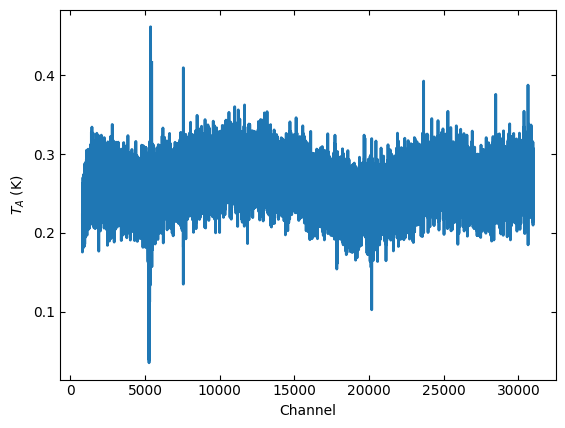

Baselining the clean spectrum...
Order: 0, BIC: -218550.443
Order: 1, BIC: -218560.335
Order: 2, BIC: -218557.484
Order: 3, BIC: -221380.214
Order: 4, BIC: -221375.951
Order: 5, BIC: -223879.456
Order: 6, BIC: -224207.200
Order: 7, BIC: -226807.113
Order: 8, BIC: -226903.577
Order: 9, BIC: -226985.536
Order: 10, BIC: -227348.854
Order: 11, BIC: -227344.185
Order: 12, BIC: -227518.169
Order: 13, BIC: -227512.760
Order: 14, BIC: -227559.687
Order: 15, BIC: -227549.609
Order: 16, BIC: -227538.836
Order: 17, BIC: -227527.791
Early stopping: no improvement

Recommended polynomial order (BIC): 14
Smoothing the clean spectrum...
33.30815680378907


Adjusting decimation factor to be a natural number. Will decimate by 33
Final spectrum:


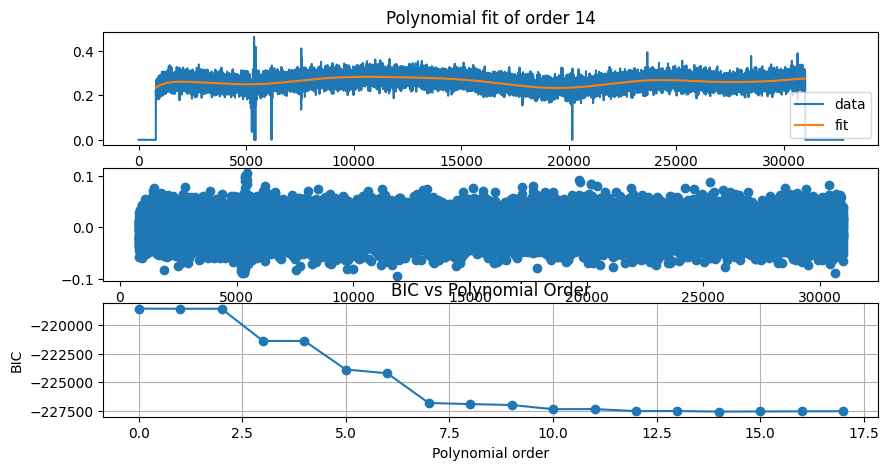

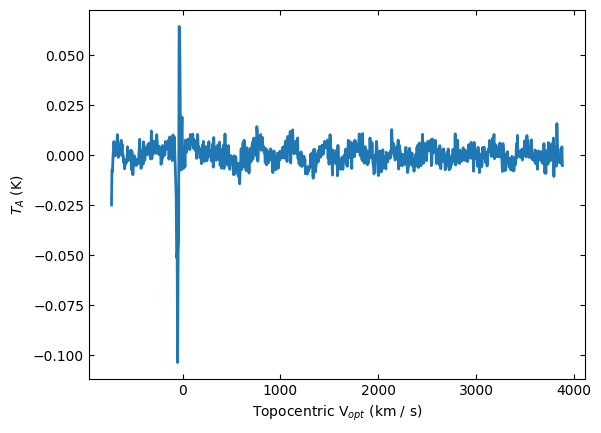

Reduction complete.


In [91]:
BC17.plot_reduced_spectra()

In [65]:
BC17.show_flag()


 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


In [66]:
BC17.flag_list()

Processing scan: 18
18 number, flags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 2

In [67]:
BC17.dropping_bad_scans()

In [68]:
BC17.scans

12    18
13    19
14    20
15    21
16    22
17    23
18    24
19    25
20    26
21    27
22    28
23    29
Name: SCAN, dtype: int64

INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


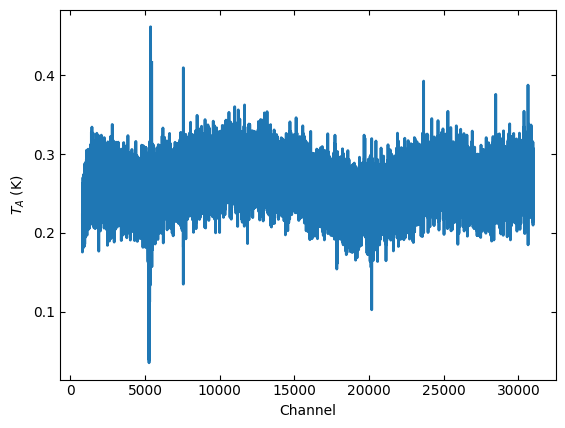

In [69]:
BC17.clean_spectrum()

Order: 0, BIC: -218550.443
Order: 1, BIC: -218560.335
Order: 2, BIC: -218557.484
Order: 3, BIC: -221380.214
Order: 4, BIC: -221375.951
Order: 5, BIC: -223879.456
Order: 6, BIC: -224207.200
Order: 7, BIC: -226807.113
Order: 8, BIC: -226903.577
Order: 9, BIC: -226985.536
Order: 10, BIC: -227348.854
Order: 11, BIC: -227344.185
Order: 12, BIC: -227518.169
Order: 13, BIC: -227512.760
Order: 14, BIC: -227559.687
Order: 15, BIC: -227549.609
Order: 16, BIC: -227538.836
Order: 17, BIC: -227527.791
Early stopping: no improvement

Recommended polynomial order (BIC): 14


AttributeError: 'Axes' object has no attribute 'xlabel'

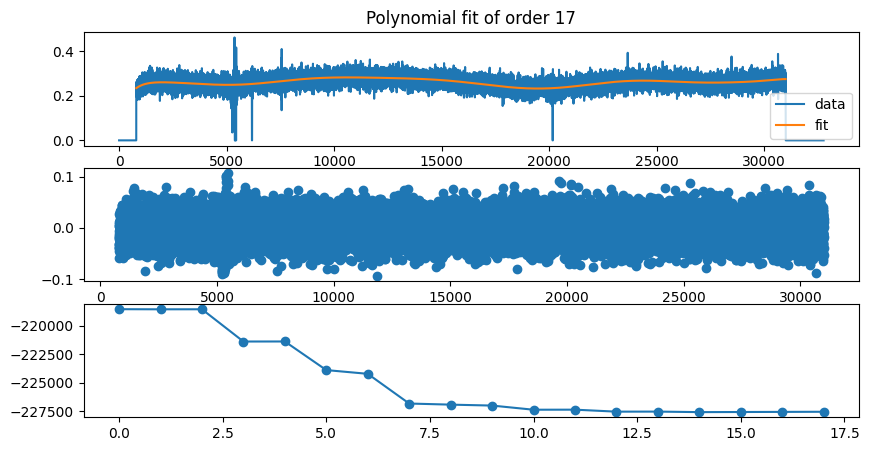

In [70]:
BC17.baselining()